In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv("/content/Churn_Modelling (1).csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
y1=df['Exited'].to_numpy()
s=len(y1==1)/len(y1)
s


1.0

In [ ]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
# 1. Drop unnecessary columns
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [ ]:
# 2. Encode Gender
gender_map = {"Female": 0, "Male": 1}
df["Gender"] = df["Gender"].map(gender_map)

In [ ]:
# 3. One-hot encode Geography (drop France to avoid dummy trap)
df = pd.get_dummies(df, columns=["Geography"], drop_first=True)

In [ ]:
# 4. Define X and y
X = df.drop("Exited", axis=1).values
y = df["Exited"].values.reshape(-1, 1)

In [ ]:
#  Z-Score Normalize function
def normalize(X):
    X = np.array(X, dtype=np.float64)
    mean = X.mean(axis=0)
    std = X.std(axis=0)
                                                #x-mean/std(z-score)
    if np.isscalar(std):
        std = np.full_like(mean, std)
        std[std == 0] = 1e-8

    return (X - mean) / std, mean, std

# Normalize original X first!
X, X_mean, X_std = normalize(X)

In [ ]:
X

array([[-0.32622142, -1.09598752,  0.29351742, ...,  0.02188649,
        -0.57873591, -0.57380915],
       [-0.44003595, -1.09598752,  0.19816383, ...,  0.21653375,
        -0.57873591,  1.74273971],
       [-1.53679418, -1.09598752,  0.29351742, ...,  0.2406869 ,
        -0.57873591, -0.57380915],
       ...,
       [ 0.60498839, -1.09598752, -0.27860412, ..., -1.00864308,
        -0.57873591, -0.57380915],
       [ 1.25683526,  0.91241915,  0.29351742, ..., -0.12523071,
         1.72790383, -0.57380915],
       [ 1.46377078, -1.09598752, -1.04143285, ..., -1.07636976,
        -0.57873591, -0.57380915]])

In [ ]:
X_mean

array([6.50528800e+02, 5.45700000e-01, 3.89218000e+01, 5.01280000e+00,
       7.64858893e+04, 1.53020000e+00, 7.05500000e-01, 5.15100000e-01,
       1.00090240e+05, 2.50900000e-01, 2.47700000e-01])

In [ ]:
X_std

array([9.66484660e+01, 4.97907130e-01, 1.04872820e+01, 2.89202976e+00,
       6.23942853e+04, 5.81625275e-01, 4.55817672e-01, 4.99771938e-01,
       5.75076172e+04, 4.33531072e-01, 4.31676627e-01])

In [ ]:
# 7. Manual train-test split
def train_test_split_manual(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2)

# 8. Confirm final shapes
print(" Train shape:", X_train.shape)
print(" Test shape:", X_test.shape)


 Train shape: (8000, 11)
 Test shape: (2000, 11)


In [ ]:
# --- Activations ---
def linear(H):
    return H

def ReLU(H):
    return H * (H > 0)

def sigmoid(H):
    return 1 / (1 + np.exp(-H))

def softmax(H):
    eH = np.exp(H)
    return eH / eH.sum(axis=1, keepdims=True)

In [ ]:
# --- Loss Functions ---
def cross_entropy(Y, P_hat):
    return -(1 / len(Y)) * np.sum(Y * np.log(P_hat))

def OLS(Y, Y_hat):
    return (1 / (2 * len(Y))) * np.sum((Y - Y_hat) ** 2)

#Misc
def one_hot(y):
    N = len(y)
    K = len(set(y))
    Y = np.zeros((N, K))
    for i in range(N):
        Y[i, y[i]] = 1
    return Y

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

def R2(y, y_hat):
    return 1 - np.sum((y - y_hat) ** 2) / np.sum((y - y.mean()) ** 2)




In [ ]:
#Derivation of activation function
def derivative(Z, a):
    if a == linear:
        return 1
    elif a == sigmoid:
        return Z * (1 - Z)
    elif a == np.tanh:
        return 1 - Z * Z
    elif a == ReLU:
        return (Z > 0).astype(int)
    else:
        raise ValueError('Unknown activation function')

In [ ]:
class ANN():
    def __init__(self, architecture, activations=None, mode=0):
        self.mode = mode
        self.architecture = architecture
        self.activations = activations
        self.L = len(architecture) + 1

    def fit(self, X, y, eta=1e-3, epochs=10000, show_curve=True):
        epochs = int(epochs)
        if self.mode:
            Y = y
            K = 1
        else:
            Y = one_hot(y)
            K = Y.shape[1]

        N, D = X.shape

        self.W = {l: np.random.randn(M[0], M[1]) for l, M in enumerate(zip(([D] + self.architecture), (self.architecture + [K])), 1)}
        self.B = {l: np.random.randn(M) for l, M in enumerate(self.architecture + [K], 1)}

        self.a = {l: act for l, act in enumerate(self.activations, 1)} if self.activations else {l: ReLU for l in range(1, self.L)}
        #self.a[self.L] = linear if self.mode else softmax
        self.a[self.L] = sigmoid if self.mode else softmax

        J = np.zeros(epochs)
        for epoch in range(epochs):
            self.__forward__(X)
            J[epoch] = OLS(Y, self.Z[self.L]) if self.mode else cross_entropy(Y, self.Z[self.L])

            dH = (1 / N) * (self.Z[self.L] - Y)

            for l in sorted(self.W.keys(), reverse=True):
                dW = self.Z[l - 1].T @ dH
                dB = dH.sum(axis=0)

                self.W[l] -= eta * dW
                self.B[l] -= eta * dB

                if l > 1:
                    dZ = dH @ self.W[l].T
                    dH = dZ * derivative(self.Z[l - 1], self.a[l - 1])

        if show_curve:
            plt.plot(J)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Training Curve")
            plt.show()

        return J

    def __forward__(self, X):
        self.Z = {0: X}
        for l in sorted(self.W.keys()):
            self.Z[l] = self.a[l](self.Z[l - 1] @ self.W[l] + self.B[l])

    def predict(self, X):
        self.__forward__(X)
        return self.Z[self.L] if self.mode else self.Z[self.L].argmax(axis=1)


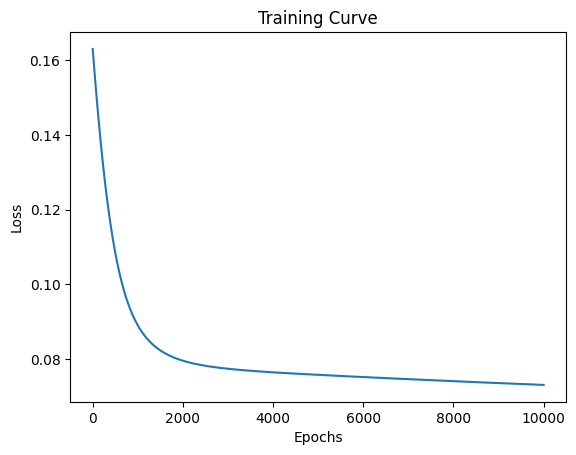

Accuracy: 0.808


In [ ]:
#ann = ANN(architecture=[10,6], activations=[np.tanh], mode=1)
#ann.fit(X_train, y_train, eta=5e-3, epochs=1e4, show_curve=True)
 #my_ann_classifier.fit(X, y, eta=5e-3, epochs=1e4)

ann = ANN(architecture=[10, 6], activations=[np.tanh, np.tanh], mode=1)
ann.fit(X_train, y_train, eta=5e-3, epochs=10000, show_curve=True)


y_pred = ann.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
print("Accuracy:", accuracy(y_test, y_pred_binary))


In [ ]:
'''#my_ann_classifier = ANN(architecture=[6,4], activations=[np.tanh,ReLU])
    #my_ann_classifier = ANN(architecture=[10,7,6], activations=[np.tanh,ReLU])
    my_ann_classifier = ANN(architecture=[10,6], activations=[np.tanh,ReLU])
    #my_ann_classifier.fit(X, y, eta=1e-3, epochs=1e3)
    #my_ann_classifier.fit(X, y, eta=1e-3, epochs=1e4)
    #my_ann_classifier.fit(X, y, eta=2e-3, epochs=1e4)
    my_ann_classifier.fit(X, y, eta=5e-3, epochs=1e4)'''

'#my_ann_classifier = ANN(architecture=[6,4], activations=[np.tanh,ReLU])\n    #my_ann_classifier = ANN(architecture=[10,7,6], activations=[np.tanh,ReLU])\n    my_ann_classifier = ANN(architecture=[10,6], activations=[np.tanh,ReLU])\n    #my_ann_classifier.fit(X, y, eta=1e-3, epochs=1e3)\n    #my_ann_classifier.fit(X, y, eta=1e-3, epochs=1e4)\n    #my_ann_classifier.fit(X, y, eta=2e-3, epochs=1e4)\n    my_ann_classifier.fit(X, y, eta=5e-3, epochs=1e4)'